# Multiple Linear Regression Analysis
### Description: 
   Regression analysis to infer weight of a Fish by given parameters.
   
### Source:
   Dataset is collected from [here](http://jse.amstat.org/jse_data_archive.htm). Then I have mapped it with given fish types in ```.csv``` format randomly shuffled.
 
    DATASET NAME: Fish Catch 
    TYPE: Sample  
    
### Plan of Action:
- [x] Assign Names to the Species
- [x] Feature Analysis
- [x] Handle/Remove Nan's
- [ ] Generate Base OLS model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd

Importing dataset

In [2]:
cols = ["Species", "Weight", "Length1", "Length2","Length3", "Height%", "Width%", "Sex"]

fish_data = pd.read_csv("fish_data.txt", delimiter="\s+", header=None
           ,index_col=0, names=cols)

fish_data.head(3)

,Species,Weight,Length1,Length2,Length3,Height%,Width%,Sex
1,1,242.0,23.2,25.4,30.0,38.4,13.4,NaN
2,1,290.0,24.0,26.3,31.2,40.0,13.8,NaN
3,1,340.0,23.9,26.5,31.1,39.8,15.1,NaN


**Feature Abstract**:  
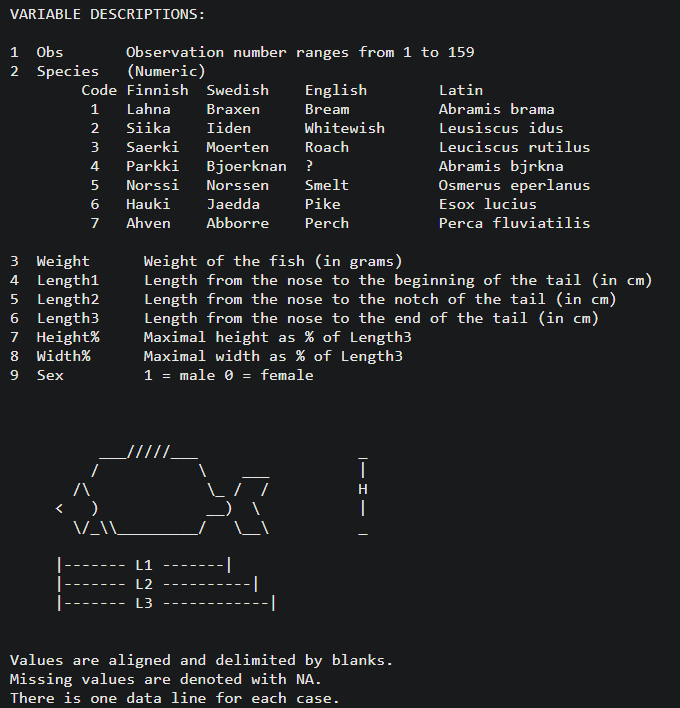

### 1. Assign Names to the Species
**Note**: Using Finnish name for ```Species=4```

In [3]:
fish_codes = {1:"Bream",2:"Whitewish", 3:"Roach", 4:"Parkki", 5:"Smelt", 6:"Pike", 7:"Perch"}

fish_data['Species'] =fish_data.Species.apply(lambda x: fish_codes[x])
fish_data.head(3)

,Species,Weight,Length1,Length2,Length3,Height%,Width%,Sex
1,Bream,242.0,23.2,25.4,30.0,38.4,13.4,NaN
2,Bream,290.0,24.0,26.3,31.2,40.0,13.8,NaN
3,Bream,340.0,23.9,26.5,31.1,39.8,15.1,NaN


In [4]:
fish_data.describe()

,Weight,Length1,Length2,Length3,Height%,Width%,Sex
count,158.000000,159.000000,159.000000,159.000000,159.000000,159.000000,72.000000
mean,398.695570,26.247170,28.415723,31.227044,28.313208,14.116352,0.236111
std,359.086204,9.996441,10.716328,11.610246,8.301122,2.274372,0.427672
min,0.000000,7.500000,8.400000,8.800000,14.500000,8.700000,0.000000
25%,120.000000,19.050000,21.000000,23.150000,24.250000,13.400000,0.000000
50%,272.500000,25.200000,27.300000,29.400000,27.100000,14.600000,0.000000
75%,650.000000,32.700000,35.500000,39.650000,37.600000,15.300000,0.000000
max,1650.000000,59.000000,63.400000,68.000000,44.500000,20.900000,1.000000


#### Remove Feature Sex
As from above, ```Sex``` has half of the labels missing.  
Let's remove ```Sex``` for now.

In [5]:
fish_data.drop(columns="Sex", inplace=True)

### 2. Feature Analysis

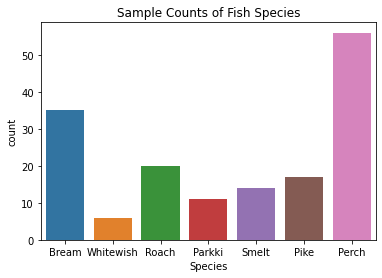

,Count,Proportion %
Perch,56,35.22
Bream,35,22.01
Roach,20,12.58
Pike,17,10.69
Smelt,14,8.81
Parkki,11,6.92
Whitewish,6,3.77


In [6]:
#Checking Species count
sns.countplot(x="Species", data=fish_data)
plt.title("Sample Counts of Fish Species")
plt.show()

display(pd.DataFrame({
    "Count": fish_data['Species'].value_counts(),
    "Proportion %": (fish_data['Species'].value_counts() * 100/ fish_data.shape[0]).apply(lambda x: np.round(x, 2))
}, index=fish_data['Species'].value_counts().index))


We have very imbalanced samples here as author suggested. He had recorded more data on ```Species = Perch``` than others.

<AxesSubplot:>

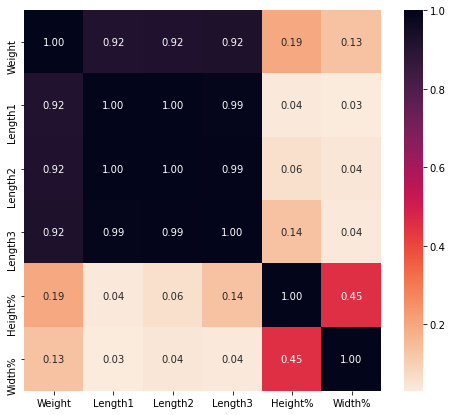

In [7]:
plt.figure(figsize=(8,7))
sns.heatmap(fish_data.corr(), annot=True, fmt=".2f", cmap="rocket_r")

So here ```Length1, Length2, Length3 ``` show a very high correlation with ```Weight``` as well as within them. So We'll possibly keep only one of them after checking for *Multicollinearity*.  
Also ```Weight``` distribution is Right Tailed.

Since author mentions that ```Height% and Weight%``` are relative to ```Length3```, we'll convert them back in units of ```Lenght3```.  

#### Added new features Height and Width

In [8]:
fish_data['Height'] = np.round(fish_data['Height%'] * fish_data['Length3'] / 100, 2)
fish_data['Width'] = np.round(fish_data['Width%'] * fish_data["Length3"] / 100, 2)

<AxesSubplot:>

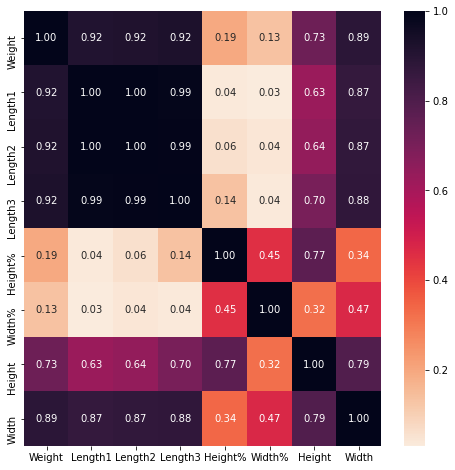

In [9]:
#Checking correlations again,
plt.figure(figsize=(8,8))
sns.heatmap(fish_data.corr(), annot=True, fmt=".2f", cmap="rocket_r")

Now we can see that ```Width``` and ```Height``` are pretty much correlated with ```Weight```.  

Also we'll keep an eye on ```Width``` for *multicollinearity*. 

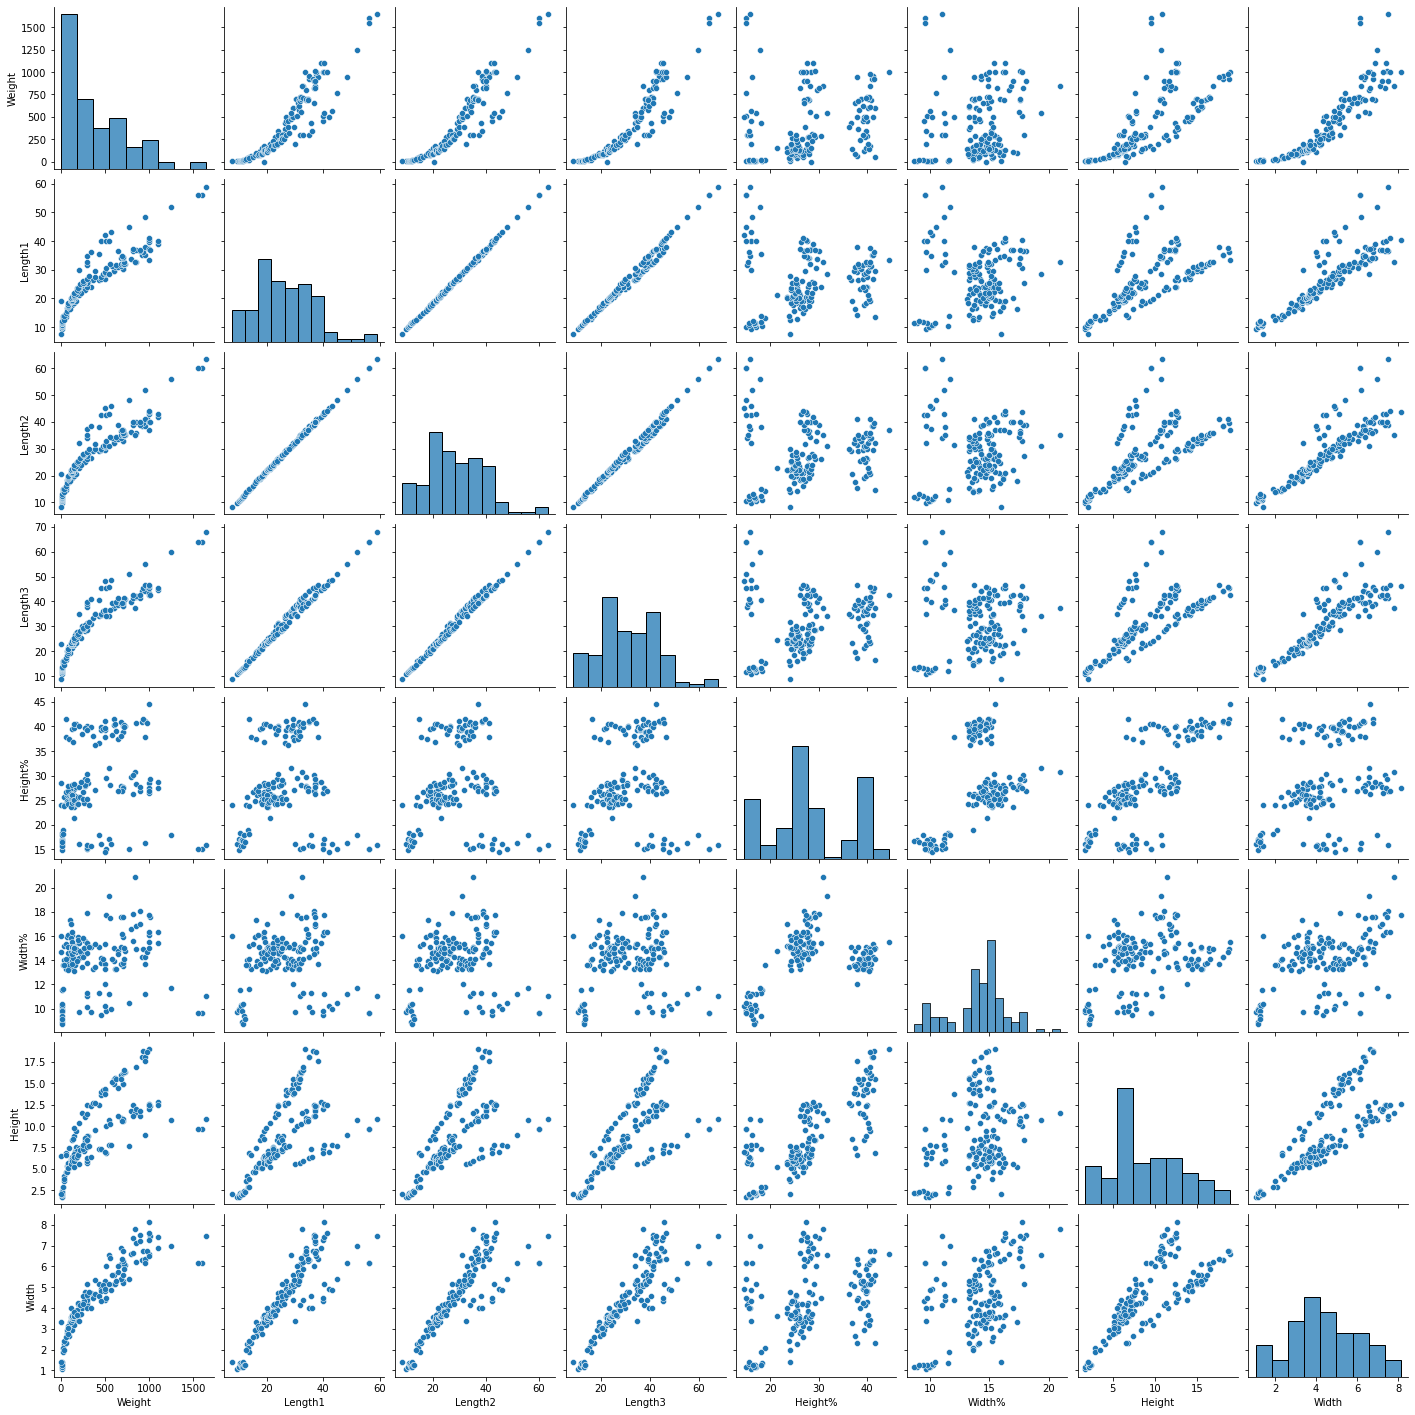

In [10]:
#Numerical Univariate and Pairwise analysis
sns.pairplot(fish_data)
plt.show()

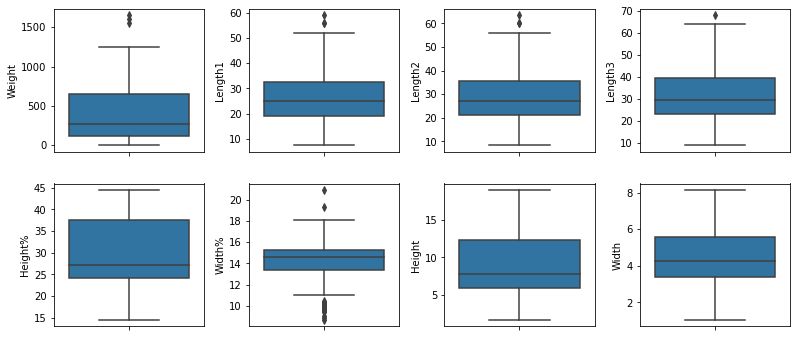

In [13]:
#Checking for feature distribution
fig,ax = plt.subplots(2, 4, figsize=(11,5))
fig.tight_layout()

for i, col in enumerate(fish_data.columns[1:]):
    sns.boxplot(y=col, data=fish_data, ax=ax[i//4, i%4])
plt.show()

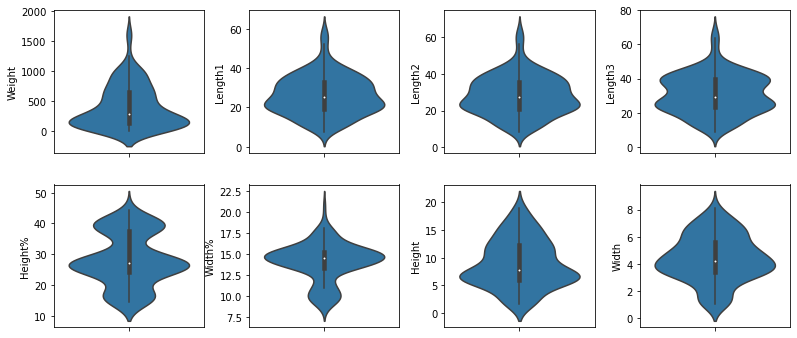

In [14]:
fig,ax = plt.subplots(2,4, figsize=(11,5))
fig.tight_layout()

for i, col in enumerate(fish_data.columns[1:]):
    sns.violinplot(y=col, data=fish_data, ax=ax[i//4, i%4])
    
plt.show()

### 3. Handling Nan's

In [17]:
#Check for nulls
fish_data.isna().sum()[fish_data.isna().sum() > 0]

Weight    1
dtype: int64

In [20]:
fish_data[fish_data.Weight.isnull()]

,Species,Weight,Length1,Length2,Length3,Height%,Width%,Height,Width
14,Bream,NaN,29.5,32.0,37.3,37.3,13.6,13.91,5.07


Since ```Species = Bream``` is one of our majority features available, we can check ```Weight``` distribution for ```Bream``` and decide whether to impute a value for the missing weight of given observation and take risk of adding noise to our data or simply remove the observation 

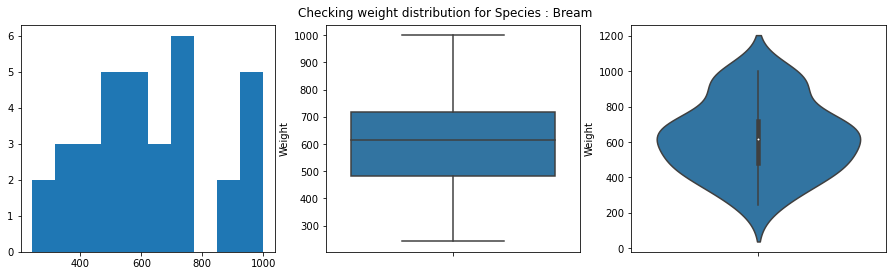

Bream Mean Weight:626.0 , Median Weight:615.0


In [60]:
fig,ax = plt.subplots(1, 3, figsize=(13,4))
fig.tight_layout( pad=2)

bream_df = fish_data[fish_data.Species == 'Bream']

ax[0].hist(bream_df.Weight)
sns.boxplot(y="Weight", data=bream_df, ax=ax[1])
sns.violinplot(y="Weight", data=bream_df, ax=ax[2])
fig.suptitle("Checking weight distribution for Species : Bream")
plt.show()

median_bream_wt = bream_df.Weight.median()
print(f"Bream Mean Weight:{bream_df.Weight.mean()} , Median Weight:{median_bream_wt}")

We can try replacing the null with Median Bream weight for now

In [62]:
fish_data.Weight.fillna(median_bream_wt, inplace=True)

fish_data.isna().sum() > 0

Species    False
Weight     False
Length1    False
Length2    False
Length3    False
Height%    False
Width%     False
Height     False
Width      False
dtype: bool

### 4. Model Building and Tuning
#### Model 1. Base OLS Multiple Regression (All Features)
Goal is to study impact of highly correlated independant variables on our prediction

In [194]:
#Prepare data
X = fish_data[['Species', 'Length1', 'Length2', 'Length3', 'Height%',
       'Width%', 'Height', 'Width']]

#Add constant for OLS requirement
X = sm.add_constant(X)

y = pd.to_numeric(fish_data['Weight'])

print(f"Shapes: X={X.shape}, y={np.shape(y)}")

Shapes: X=(159, 9), y=(159,)


We'll OneHotEncode ```Species``` and drop ```Species = Perch``` to avoid **dummy variable trap** and keep base the condition. 

In [195]:
X = pd.get_dummies(X, columns=["Species"])
X.drop(columns="Species_Perch", inplace=True)

print(f"Shapes: X={X.shape}, y={np.shape(y)}")

Shapes: X=(159, 14), y=(159,)


In [196]:
base_reg = sm.OLS(y, X, hasconst=True)
base_result = base_reg.fit()

In [197]:
base_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     180.8
Date:                Fri, 21 Jan 2022   Prob (F-statistic):           1.36e-82
Time:                        10:18:26   Log-Likelihood:                -934.04
No. Observations:                 159   AIC:                             1896.
Df Residuals:                     145   BIC:                             1939.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1479.9594    247.094     -5.989      0.000   -1968.330    -991.588
Length1             -39.0579     36.741     -1.063      0.290    -111.676      33.560
Length2              27.6025     46.008      0.600      0.549     -63.331     118.536
Length3              59.8375     29.323      2.041      0.043       1.881     117.794
Height%               5.7067      8.190      0.697      0.487     -10.480      21.893
Width%               40.7386     17.381      2.344      0.020       6.385      75.092
Height                4.5409     18.799      0.242      0.809     -32.614      41.696
Width              -105.9582     49.149     -2.156      0.033    -203.100      -8.816
Species_Bream      -214.6738    128.985     -1.664      0.098    -469.608      40.260
Species_Parkki      -56.7311    101.811     -0.557      0.578    -257.956     144.493
Species_Pike       -324.4659     74.939     -4.330      0.000    -472.581    -176.351
Species_Roach       -61.0491     47.629     -1.282      0.202    -155.186      33.087
Species_Smelt       441.0687     66.101      6.673      0.000     310.423     571.715
Species_Whitewish   -62.1609     52.961     -1.174      0.242    -166.836      42.514
==============================================================================
Omnibus:                       29.163   Durbin-Watson:                   0.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.091
Skew:                           0.930   Prob(JB):                     5.95e-11
Kurtosis:                       4.909   Cond. No.                     2.31e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

After applying OLS for features ```Length1```, ```Length2```, ```Length3```, ```Height%```, ```Width%```, ```Height```, ```Width```,
       ```Species_Bream```, ```Species_Parkki```, ```Species_Pike```, ```Species_Roach```,
       ```Species_Smelt```, ```Species_Whitewish```, we can see $R^2 = 0.942$ which suggests we have well performing model.  
       
I will treat this as baseline. Some of the features have ${P-value > 0.05}$ and thus insignificant. I'll also perform feature selection to get a model that best explains variation in our data.   
Also I will account for **Multicollinearity**, **Hetroscedasticity** of residuals and **Normality** of residuals. Also there's indication of high skewness.  

#### Multicollinearity  

I'll apply **Variance Inflation Factor**, which tried to find how much of variation in selected variable is explained by remaining other variables. High VIF suggests presence of Multicollinearity.

In [236]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.DataFrame([[col, variance_inflation_factor(X.values, X.columns.get_loc(col))] for col in X.columns]
            , index=range(X.shape[1]), columns=["Variables", "VIF"]).sort_values('VIF', ascending=False)

,Variables,VIF
2,Length2,4724.769883
1,Length1,2621.919577
3,Length3,2252.815273
0,const,1194.207113
7,Width,133.408192
6,Height,126.174324
4,Height%,89.831459
8,Species_Bream,55.863726
5,Width%,30.373828
9,Species_Parkki,13.055766


So our features display strong multicollinearity. Let's remove features with high VIF one by one post recomputing VIF and get the best possible outcome to our model.

```Python
Baseline Features- ['Length2', 'Length1', 'Length3', 'const', 'Width', 'Height','Height%', 'Species_Bream', 'Width%', 'Species_Parkki','Species_Pike', 'Species_Smelt', 'Species_Roach', 'Species_Whitewish']
```

#### Model 2. Improved Model V1

In [237]:
selected_cols = [ 'Length1',  'const',  'Species_Bream', 'Width%', 'Species_Parkki','Species_Pike', 'Species_Smelt',  ]

X_temp = X[selected_cols]

pd.DataFrame([[col, variance_inflation_factor(X_temp.values, X_temp.columns.get_loc(col))] for col in selected_cols]
            , index=range(len(selected_cols)), columns=["Variables", "VIF"]).sort_values('VIF', ascending=False)

,Variables,VIF
1,const,190.379046
5,Species_Pike,5.326604
3,Width%,4.705135
6,Species_Smelt,2.811142
0,Length1,2.786713
2,Species_Bream,1.751701
4,Species_Parkki,1.173239


In [238]:
reg_v1 = sm.OLS(y, X[selected_cols], hasconst=True)
reg_v1_summary = reg_v1.fit()
reg_v1_summary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     362.2
Date:                Fri, 21 Jan 2022   Prob (F-statistic):           2.44e-87
Time:                        10:58:01   Log-Likelihood:                -943.42
No. Observations:                 159   AIC:                             1901.
Df Residuals:                     152   BIC:                             1922.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Length1           41.6406      1.241     33.553      0.000      39.189      44.092
const           -911.0116    102.217     -8.913      0.000   -1112.961    -709.062
Species_Bream     75.9003     23.664      3.207      0.002      29.147     122.654
Width%            14.0715      7.088      1.985      0.049       0.068      28.075
Species_Parkki    87.8636     31.621      2.779      0.006      25.390     150.337
Species_Pike    -285.8665     55.331     -5.166      0.000    -395.183    -176.550
Species_Smelt    309.6058     43.833      7.063      0.000     223.005     396.207
==============================================================================
Omnibus:                       39.460   Durbin-Watson:                   0.610
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.211
Skew:                           1.142   Prob(JB):                     2.82e-17
Kurtosis:                       5.508   Cond. No.                         492.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So after several manual iterations, I found best feature combination that preserves most variance of the model and also keeps significant features with multicollinearity removed.
```Python
Best Features - ['Length1',  'const',  'Species_Bream', 'Width%', 'Species_Parkki','Species_Pike', 'Species_Smelt'] 
```
Best Feature stats: ${R^2 = 0.935}$  

Note that we had to remove features specifying below species, which we need for our final interpretation. 
```Python 
    Species = ['Bream', 'Whitewish', 'Roach']  
```
**TODO:** I'll later try to introduce some *Interaction Terms* and/or *NonLinear Transformations* to get proper relations.

#### Are Residuals Normally Distributed?

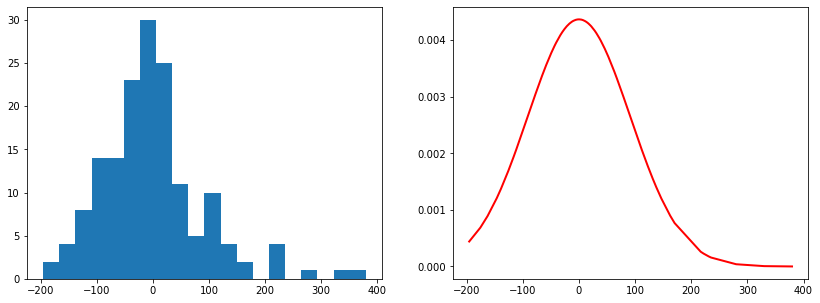

In [248]:
import scipy.stats as stats

mu , sigma = np.mean(reg_v1_summary.resid), np.std(reg_v1_summary.resid)
pdf = stats.norm.pdf(sorted(reg_v1_summary.resid), mu, sigma)

fig,ax = plt.subplots(1,2, figsize=(14,5))
ax[0].hist(reg_v1_summary.resid, bins=20)
ax[1].plot(sorted(reg_v1_summary.resid), pdf, color='r', linewidth=2)

plt.show()

Distribution of Residuals does not follow perfectly normal distribution with ```skew = 0 , excess kurtosis = 0```. There are small number of outliers to the right and the tail is a bit fatter, that explains distribution has ```kurtosis = 5```.  

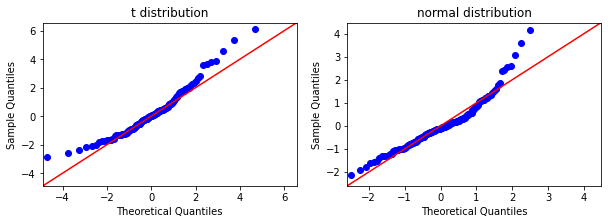

In [250]:
# QQplot
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,3))
sm.qqplot(reg_v1_summary.resid, stats.t, fit=True, line='45', ax = ax1)
ax1.set_title("t distribution")

sm.qqplot(reg_v1_summary.resid, stats.norm, fit=True, line='45', ax=ax2)
ax2.set_title("normal distribution")
plt.show()

Seems like model follows normal distribution better than t-distribution with some outliers. We'll check this later post adding new variables and retraining.

#### Hetroscedasticity

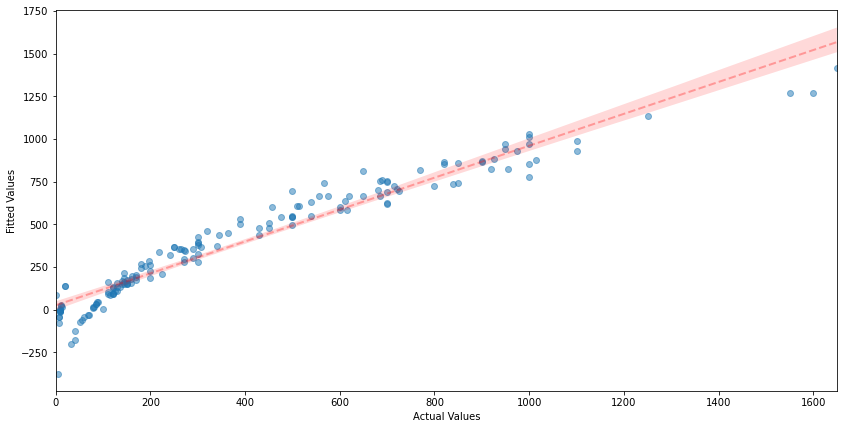

Pearson R: (0.9667628915436484, 6.679503858854091e-95)


In [256]:
plt.figure(figsize=(14,7))

sns.regplot(x=y, y=reg_v1_summary.fittedvalues, 
           line_kws={
               'color':'r', 'alpha':0.3, 'linestyle':'--', 'linewidth':2
           },
            scatter_kws={ 'alpha':0.5})
plt.xlabel("Actual Values")
plt.ylabel("Fitted Values")
plt.show()

print("Pearson R:", stats.pearsonr(reg_v1_summary.fittedvalues, y))

Consistent with our reported ${R^2}$. Although we can see some weights have been reported in negative, which is completely wrong judgement. We'll have to find out the root cause.

Let's now visualize strength of the correlation between predicted and actual weights by fitting a line on Residuals vs Actual weights.

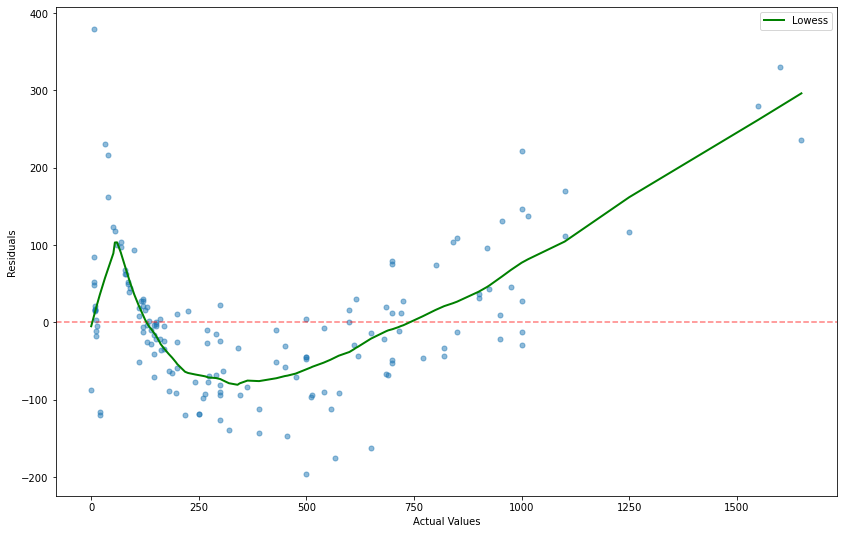

Pearson R: (0.2556746204341848, 0.0011430067539648535)


In [266]:
from statsmodels.nonparametric.smoothers_lowess import lowess

ys = lowess(reg_v1_summary.resid.values, y, frac=0.2)
ys = pd.DataFrame(ys, index=range(len(ys)), columns=['a', 'b'])
ys = ys.sort_values(by='a')

fig, ax = plt.subplots(figsize=(14,9))
plt.scatter(y, reg_v1_summary.resid, alpha=0.5, s=25)
plt.axhline(y=0, color='r', linestyle="--", alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Residuals")

plt.plot(ys.a, ys.b, c='green', linewidth=2, label="Lowess")
plt.legend()
plt.show()
print("Pearson R:", stats.pearsonr(y, reg_v1_summary.resid))

As we can see, the model tends to overestimate fishes with smaller and larger weights along with the fact that weights are negative.  

So our model was inconsistent in actually providing proper estimation of weight.

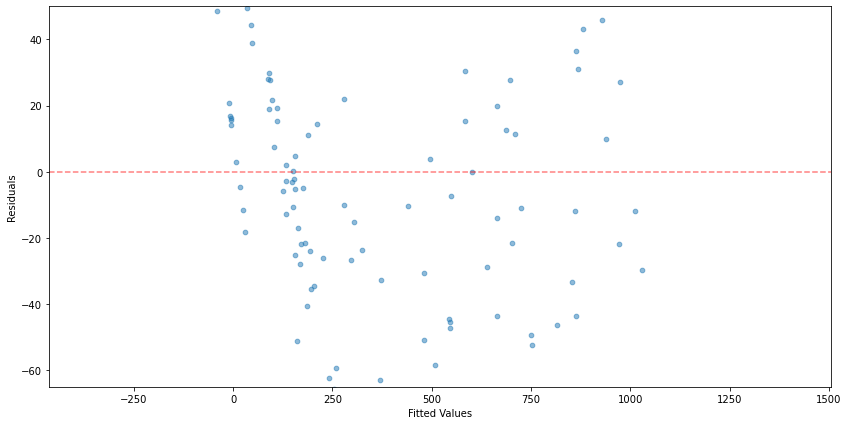

In [269]:
# plot actual values versus residuals
plt.figure(figsize=(14,7))

plt.scatter(y=reg_v1_summary.resid, x=reg_v1_summary.fittedvalues, alpha=0.5, s=22)
plt.axhline(y=0, color='r', linestyle="--", alpha=0.5)

plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.ylim(-65, 50)
plt.show()

Above plot shows that residuals are widely distributed.